##**Importing Libraries**

In [ ]:
import os
import sys
import cv2
import glob
import torch
import joblib
import shutil
import random
import argparse
import simpledorff
import tensorboard
import torchvision

import numpy as np
import pylab as pl
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data

from tqdm import tqdm
from PIL import Image
from torchsummary import summary
from sklearn.svm import LinearSVC
from scipy.cluster.vq import kmeans,vq
from disagree import Metrics, Krippendorff
from torchvision import transforms, datasets
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay,mean_squared_error

%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# verifying GPU runtime

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

##**Data Handling, Preprocessing, & Loading**

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extracting train and validation set
!tar -xvf "/content/drive/MyDrive/AffectNet/train_and_val_set.tar"

Streaming output truncated to the last 5000 lines.
train_set/annotations/392066_lnd.npy
train_set/annotations/83536_lnd.npy
train_set/annotations/26361_lnd.npy
train_set/annotations/313969_aro.npy
train_set/annotations/286825_exp.npy
train_set/annotations/392215_aro.npy
train_set/annotations/330087_lnd.npy
train_set/annotations/110001_val.npy
train_set/annotations/371482_aro.npy
train_set/annotations/27940_aro.npy
train_set/annotations/35729_exp.npy
train_set/annotations/156731_aro.npy
train_set/annotations/145081_aro.npy
train_set/annotations/93043_exp.npy
train_set/annotations/279607_lnd.npy
train_set/annotations/48472_lnd.npy
train_set/annotations/206512_exp.npy
train_set/annotations/84264_aro.npy
train_set/annotations/187769_lnd.npy
train_set/annotations/300707_exp.npy
train_set/annotations/123766_exp.npy
train_set/annotations/173216_aro.npy
train_set/annotations/262096_lnd.npy
train_set/annotations/194946_aro.npy
train_set/annotations/411301_aro.npy
train_set/annotations/43103_aro

In [ ]:
# extracting test set
!tar -xvf "/content/drive/MyDrive/AffectNet/test_set.tar"

Streaming output truncated to the last 5000 lines.
val_set/annotations/678_lnd.npy
val_set/annotations/1526_lnd.npy
val_set/annotations/5420_aro.npy
val_set/annotations/4628_exp.npy
val_set/annotations/5254_lnd.npy
val_set/annotations/4769_aro.npy
val_set/annotations/1994_lnd.npy
val_set/annotations/4840_lnd.npy
val_set/annotations/3546_val.npy
val_set/annotations/2606_lnd.npy
val_set/annotations/1282_val.npy
val_set/annotations/948_lnd.npy
val_set/annotations/2672_lnd.npy
val_set/annotations/1599_aro.npy
val_set/annotations/2177_exp.npy
val_set/annotations/1830_val.npy
val_set/annotations/4676_aro.npy
val_set/annotations/3228_aro.npy
val_set/annotations/5196_aro.npy
val_set/annotations/714_val.npy
val_set/annotations/2296_exp.npy
val_set/annotations/934_lnd.npy
val_set/annotations/1511_val.npy
val_set/annotations/2923_exp.npy
val_set/annotations/4198_aro.npy
val_set/annotations/886_lnd.npy
val_set/annotations/1924_exp.npy
val_set/annotations/1462_lnd.npy
val_set/annotations/812_exp.np

In [ ]:
# defining image resolution, default batch size, and epsilon for thresholding

image_size = 224
batch_size = 64
eps = sys.float_info.epsilon

In [ ]:
# defining data transforms

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((image_size,image_size)),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225]),
                                            ])

In [ ]:
# defining number of images in train, validation, and test sets

n_train = int(0.8*len(os.listdir("/content/train_set/images/")))
n_val = len(os.listdir("/content/train_set/images/")) - n_train
n_test = len(os.listdir("/content/val_set/images/"))

print("Number of images in train set:", n_train)
print("Number of images in validation set:", n_val)
print("Number of images in test set:", n_test)

Number of images in train set: 230120
Number of images in validation set: 57531
Number of images in test set: 3999


In [ ]:
# defining pandas dataframe for train and validation set

train_val_path = '/content/train_set/'

data_train_val = []
        
for anno in glob.glob(train_val_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(train_val_path,f'images/{idx}.jpg')
  label = int(np.load(train_val_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(train_val_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(train_val_path + 'annotations/' + idx + '_aro.npy'))
  data_train_val.append([img_path,label,valence,arousal])

train_val_df = pd.DataFrame(data = data_train_val,columns = ['img_path','label','valence','arousal'])

In [ ]:
train_val_df.head()

,img_path,label,valence,arousal
0,/content/train_set/images/332455.jpg,1,0.861401,0.096787
1,/content/train_set/images/26690.jpg,1,0.526759,0.142225
2,/content/train_set/images/119245.jpg,1,0.666667,0.246032
3,/content/train_set/images/56912.jpg,0,0.007937,-0.007937
4,/content/train_set/images/228932.jpg,6,-0.611111,0.293651


In [ ]:
train_val_df.shape

(287651, 4)

In [ ]:
# defining pandas dataframe for test set

test_path = '/content/val_set/'

data_test = []
        
for anno in glob.glob(test_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(test_path,f'images/{idx}.jpg')
  label = int(np.load(test_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(test_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(test_path + 'annotations/' + idx + '_aro.npy'))
  data_test.append([img_path,label,valence,arousal])

test_df = pd.DataFrame(data = data_test,columns = ['img_path','label','valence','arousal'])

In [ ]:
test_df.head()

,img_path,label,valence,arousal
0,/content/val_set/images/2800.jpg,5,-0.904762,0.373016
1,/content/val_set/images/995.jpg,1,0.531746,0.015873
2,/content/val_set/images/3873.jpg,5,-0.745257,0.493612
3,/content/val_set/images/1244.jpg,0,0.007937,0.000000
4,/content/val_set/images/2873.jpg,0,0.012940,-0.008627


In [ ]:
test_df.shape

(3999, 4)

In [ ]:
n_rows = 134000
class_col = 'label'

# grouping data by classes
s_train_val_df = train_val_df.groupby(class_col, group_keys=False).apply(lambda x: x.sample(min(len(x), n_rows)))

In [ ]:
# custom class inherited from Dataset
class data_set(data.Dataset):
 
  def __init__(self, dataframe_name, transform = None):
    self.data = dataframe_name

    self.file_paths = self.data.loc[:, 'img_path'].values
    self.label = self.data.loc[:, 'label'].values
    self.valence = self.data.loc[:, 'valence'].values
    self.arousal = self.data.loc[:, 'arousal'].values

    _, self.sample_counts = np.unique(self.label, return_counts=True)
 

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]
        valence = self.valence[idx]
        arousal = self.arousal[idx]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

  def len(self):
      return len(self.file_paths)

In [ ]:
train_val_data_set = data_set(train_val_df, transform = transform)

In [ ]:
train_val_data_set.sample_counts

array([ 74874, 134415,  25459,  14090,   6378,   3803,  24882,   3750])

In [ ]:
test_data_set = data_set(test_df, transform = transform)

In [ ]:
test_data_set.sample_counts

array([500, 500, 500, 500, 500, 500, 500, 499])

In [ ]:
# making directories for test set
for i in range(8):
  dir_path = 'test/' + str(i)
  os.makedirs(dir_path)

In [ ]:
# formatting the test dataset into class folders
for i in range(8):
  for c in list(test_df[test_df['label']== i]['img_path']):
    get_image = os.path.join('/content/val_set/images/', c)
    move_image = shutil.copy(get_image, '/content/test/' + str(i))

In [ ]:
# making directories for train and validation set
for i in range(8):
  dir_path = 'train/' + str(i)
  os.makedirs(dir_path)

In [ ]:
# formatting the train and validation dataset into class folders
for i in range(8):
  for c in list(s_train_val_df[s_train_val_df['label']== i]['img_path']):
    get_image = os.path.join('/content/train_set/images/', c)
    move_image = shutil.copy(get_image, '/content/train/' + str(i))

In [ ]:
path = '/content/train'

# defining the dataset for training and validation
data_set = torchvision.datasets.ImageFolder(root=path, transform=transform)

In [ ]:
n_train = 0.8*s_train_val_df.shape[0]
n_val = 0.2*s_train_val_df.shape[0]

# defining the train and validation datasets
train_set, val_set = torch.utils.data.random_split(data_set, [int(n_train)+1, int(n_val)], generator=torch.Generator().manual_seed(42))

In [ ]:
path = '/content/test'

# defining the test_set dataset
test_set = torchvision.datasets.ImageFolder(root=path, transform=transform)

In [ ]:
def show_dataset_samples(data_set):
    loader = torch.utils.data.DataLoader(
    data_set,
    batch_size=32,
    shuffle=True)

  # getting a batch of images from the train_loader
    images, labels = next(iter(loader))

    rows = col = 3
    #fig, axes = plt.subplots(nrows=5, ncols=5)
    plt.figure(figsize = (10,10))

    for i in range(rows*col):
      # plotting a random image from the batch
      random_index = np.random.randint(0, images.shape[0])
      image = images[random_index]
      label = labels[random_index]
      plt.subplot(rows, col, i+1)
      plt.axis('off')
      plt.imshow(image.permute(1,2,0))
      
      if hasattr(train_set, 'classes'):
        classes = train_set.classes
      elif hasattr(train_set, 'dataset') and hasattr(train_set.dataset, 'classes'):
        classes = train_set.dataset.classes

      plt.title(f'Label: {classes[label]}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


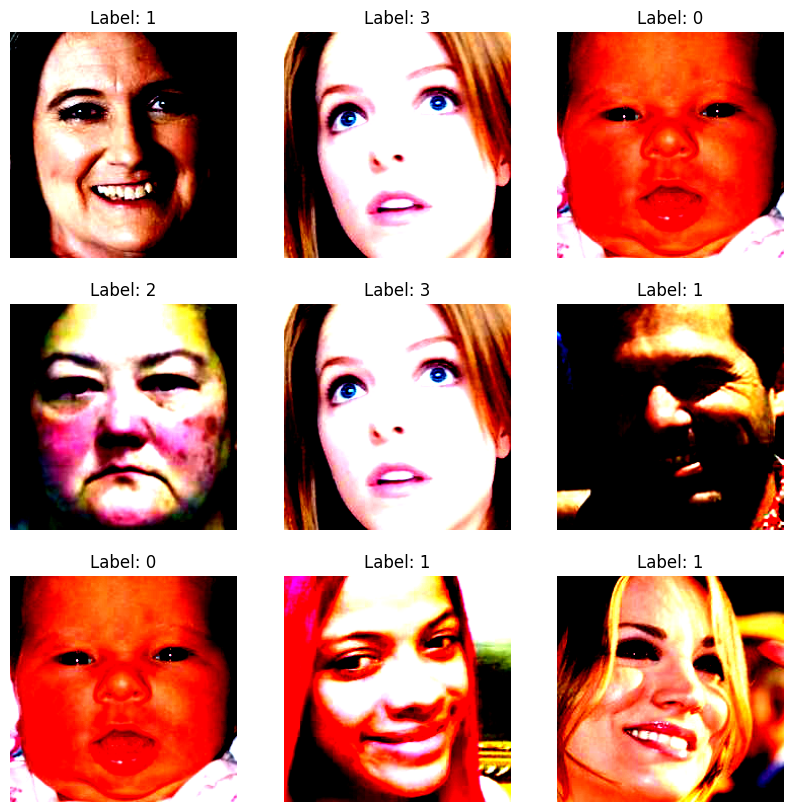

In [ ]:
# showing normalized dataset samples
show_dataset_samples(train_set)

In [ ]:
# function for updating the dataset transforms
def update_transform(dataset, transform):
    if hasattr(dataset, 'transform'):
      dataset.transform = transform
      dataset.transform
    elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'transform'):
      dataset.dataset.transform = transform
      dataset.dataset.transform
    else:
      print("No transform attribute found.")

In [ ]:
# composing transforms for data augmentation
augmentation_transforms = torchvision.transforms.Compose([transform,
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.GaussianBlur(5)
    ])

# adding data augmentation transform to the train_set
update_transform(train_set, transform)

In [ ]:
# populating train loader
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

# populating validation loader
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False
)

# populating test loader
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

##**VGG-19**

In [ ]:
model = torchvision.models.vgg19(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[-1] = nn.Linear(in_features=4096, out_features= 8)

In [ ]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f2c84c69150>

In [ ]:
for name, parameter in model.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: features.0.weight,	Shape: torch.Size([64, 3, 3, 3])
Name: features.0.bias,	Shape: torch.Size([64])
Name: features.2.weight,	Shape: torch.Size([64, 64, 3, 3])
Name: features.2.bias,	Shape: torch.Size([64])
Name: features.5.weight,	Shape: torch.Size([128, 64, 3, 3])
Name: features.5.bias,	Shape: torch.Size([128])
Name: features.7.weight,	Shape: torch.Size([128, 128, 3, 3])
Name: features.7.bias,	Shape: torch.Size([128])
Name: features.10.weight,	Shape: torch.Size([256, 128, 3, 3])
Name: features.10.bias,	Shape: torch.Size([256])
Name: features.12.weight,	Shape: torch.Size([256, 256, 3, 3])
Name: features.12.bias,	Shape: torch.Size([256])
Name: features.14.weight,	Shape: torch.Size([256, 256, 3, 3])
Name: features.14.bias,	Shape: torch.Size([256])
Name: features.16.weight,	Shape: torch.Size([256, 256, 3, 3])
Name: features.16.bias,	Shape: torch.Size([256])
Name: features.19.weight,	Shape: torch.Size([512, 256, 3, 3])
Name: features.19.bias,	Shape: torch.Size([512])
Name: features.21

In [ ]:
for name, parameter in model.named_parameters():
  if name.startswith('classifier.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: classifier.0.weight,	Shape: torch.Size([4096, 25088])
Name: classifier.0.bias,	Shape: torch.Size([4096])
Name: classifier.3.weight,	Shape: torch.Size([4096, 4096])
Name: classifier.3.bias,	Shape: torch.Size([4096])
Name: classifier.6.weight,	Shape: torch.Size([8, 4096])
Name: classifier.6.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model2 = modified_net(model2)

In [ ]:
model.features.children()

<generator object Module.children at 0x7f2c84c69c40>

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

**Main Training Loop**

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 800/800 [08:07<00:00,  1.64it/s]


Epoch 0: Validation


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train loss: 1.9724
val loss: 1.8423
train_accuracy 25.43
val_accuracy 29.26
New max val Accuracy Acheived 29.26. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 800/800 [08:06<00:00,  1.65it/s]


Epoch 1: Validation


100%|██████████| 200/200 [02:00<00:00,  1.65it/s]


train loss: 1.9584
val loss: 1.8229
train_accuracy 26.79
val_accuracy 31.05
New max val Accuracy Acheived 31.05. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 800/800 [07:58<00:00,  1.67it/s]


Epoch 2: Validation


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


train loss: 1.9567
val loss: 1.8395
train_accuracy 27.33
val_accuracy 30.85
val accuracy did not increase from 31.05


Epoch 3: Train 
Learning Rate: 0.001000


  9%|▉         | 71/800 [00:43<07:22,  1.65it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')

##**ResNet-152**

In [ ]:
model2 = torchvision.models.resnet152(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 66.7MB/s]


In [ ]:
for param in model2.parameters():
    param.requires_grad = False

In [ ]:
model2.fc = nn.Linear(in_features=2048, out_features= 8)

In [ ]:
model2.named_parameters()

<generator object Module.named_parameters at 0x7f33b7faab20>

In [ ]:
for name, parameter in model2.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: conv1.weight,	Shape: torch.Size([64, 3, 7, 7])
Name: bn1.weight,	Shape: torch.Size([64])
Name: bn1.bias,	Shape: torch.Size([64])
Name: layer1.0.conv1.weight,	Shape: torch.Size([64, 64, 1, 1])
Name: layer1.0.bn1.weight,	Shape: torch.Size([64])
Name: layer1.0.bn1.bias,	Shape: torch.Size([64])
Name: layer1.0.conv2.weight,	Shape: torch.Size([64, 64, 3, 3])
Name: layer1.0.bn2.weight,	Shape: torch.Size([64])
Name: layer1.0.bn2.bias,	Shape: torch.Size([64])
Name: layer1.0.conv3.weight,	Shape: torch.Size([256, 64, 1, 1])
Name: layer1.0.bn3.weight,	Shape: torch.Size([256])
Name: layer1.0.bn3.bias,	Shape: torch.Size([256])
Name: layer1.0.downsample.0.weight,	Shape: torch.Size([256, 64, 1, 1])
Name: layer1.0.downsample.1.weight,	Shape: torch.Size([256])
Name: layer1.0.downsample.1.bias,	Shape: torch.Size([256])
Name: layer1.1.conv1.weight,	Shape: torch.Size([64, 256, 1, 1])
Name: layer1.1.bn1.weight,	Shape: torch.Size([64])
Name: layer1.1.bn1.bias,	Shape: torch.Size([64])
Name: layer1.1.con

In [ ]:
for name, parameter in model2.named_parameters():
  if name.startswith('fc.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: fc.weight,	Shape: torch.Size([8, 2048])
Name: fc.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model2 = modified_net(model2)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model2.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model2, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model2, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model2.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model2.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 1351/1351 [16:22<00:00,  1.38it/s]


Epoch 0: Validation


100%|██████████| 338/338 [03:50<00:00,  1.46it/s]


train loss: 1.6650
val loss: 1.5931
train_accuracy 37.92
val_accuracy 40.42
New max val Accuracy Acheived 40.42. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 1351/1351 [15:54<00:00,  1.42it/s]


Epoch 1: Validation


100%|██████████| 338/338 [03:47<00:00,  1.49it/s]


train loss: 1.5981
val loss: 1.6051
train_accuracy 41.17
val_accuracy 40.88
New max val Accuracy Acheived 40.88. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


100%|██████████| 1351/1351 [15:48<00:00,  1.42it/s]


Epoch 2: Validation


100%|██████████| 338/338 [03:46<00:00,  1.49it/s]


train loss: 1.5657
val loss: 1.6055
train_accuracy 42.55
val_accuracy 41.37
New max val Accuracy Acheived 41.37. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  3%|▎         | 43/1351 [00:31<15:49,  1.38it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')

##**Swin-V2**

In [ ]:
model3 = torchvision.models.swin_b(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model3.parameters():
    param.requires_grad = False

In [ ]:
model3.head = nn.Linear(in_features=1024, out_features= 8)

In [ ]:
model3.named_parameters()

<generator object Module.named_parameters at 0x7f337667eab0>

In [ ]:
for name, parameter in model3.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: features.0.0.weight,	Shape: torch.Size([128, 3, 4, 4])
Name: features.0.0.bias,	Shape: torch.Size([128])
Name: features.0.2.weight,	Shape: torch.Size([128])
Name: features.0.2.bias,	Shape: torch.Size([128])
Name: features.1.0.norm1.weight,	Shape: torch.Size([128])
Name: features.1.0.norm1.bias,	Shape: torch.Size([128])
Name: features.1.0.attn.relative_position_bias_table,	Shape: torch.Size([169, 4])
Name: features.1.0.attn.qkv.weight,	Shape: torch.Size([384, 128])
Name: features.1.0.attn.qkv.bias,	Shape: torch.Size([384])
Name: features.1.0.attn.proj.weight,	Shape: torch.Size([128, 128])
Name: features.1.0.attn.proj.bias,	Shape: torch.Size([128])
Name: features.1.0.norm2.weight,	Shape: torch.Size([128])
Name: features.1.0.norm2.bias,	Shape: torch.Size([128])
Name: features.1.0.mlp.0.weight,	Shape: torch.Size([512, 128])
Name: features.1.0.mlp.0.bias,	Shape: torch.Size([512])
Name: features.1.0.mlp.3.weight,	Shape: torch.Size([128, 512])
Name: features.1.0.mlp.3.bias,	Shape: torch

In [ ]:
for name, parameter in model3.named_parameters():
  if name.startswith('head.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: head.weight,	Shape: torch.Size([8, 1024])
Name: head.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model3 = modified_net(model3)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model3.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model3, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model3, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model3.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model3.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/1351 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1351/1351 [22:18<00:00,  1.01it/s]


Epoch 0: Validation


100%|██████████| 338/338 [05:30<00:00,  1.02it/s]


train loss: 1.6520
val loss: 1.5541
train_accuracy 38.59
val_accuracy 42.96
New max val Accuracy Acheived 42.96. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


 19%|█▉        | 262/1351 [04:19<18:00,  1.01it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')

##**EfficientNet**

In [ ]:
model4 = torchvision.models.efficientnet_v2_l(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 72.6MB/s]


In [ ]:
for param in model4.parameters():
    param.requires_grad = False

In [ ]:
model4.classifier = nn.Linear(in_features=1280, out_features= 8)

In [ ]:
model4.named_parameters()

<generator object Module.named_parameters at 0x7fbd919bcdd0>

In [ ]:
for name, parameter in model4.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: features.0.0.weight,	Shape: torch.Size([32, 3, 3, 3])
Name: features.0.1.weight,	Shape: torch.Size([32])
Name: features.0.1.bias,	Shape: torch.Size([32])
Name: features.1.0.block.0.0.weight,	Shape: torch.Size([32, 32, 3, 3])
Name: features.1.0.block.0.1.weight,	Shape: torch.Size([32])
Name: features.1.0.block.0.1.bias,	Shape: torch.Size([32])
Name: features.1.1.block.0.0.weight,	Shape: torch.Size([32, 32, 3, 3])
Name: features.1.1.block.0.1.weight,	Shape: torch.Size([32])
Name: features.1.1.block.0.1.bias,	Shape: torch.Size([32])
Name: features.1.2.block.0.0.weight,	Shape: torch.Size([32, 32, 3, 3])
Name: features.1.2.block.0.1.weight,	Shape: torch.Size([32])
Name: features.1.2.block.0.1.bias,	Shape: torch.Size([32])
Name: features.1.3.block.0.0.weight,	Shape: torch.Size([32, 32, 3, 3])
Name: features.1.3.block.0.1.weight,	Shape: torch.Size([32])
Name: features.1.3.block.0.1.bias,	Shape: torch.Size([32])
Name: features.2.0.block.0.0.weight,	Shape: torch.Size([128, 32, 3, 3])
Name

In [ ]:
for name, parameter in model4.named_parameters():
  if name.startswith('classifier.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: classifier.weight,	Shape: torch.Size([8, 1280])
Name: classifier.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model4 = modified_net(model4)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model4.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model4, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model4, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model4.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model4.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


100%|██████████| 3591/3591 [58:20<00:00,  1.03it/s]


Epoch 0: Validation


100%|██████████| 898/898 [13:31<00:00,  1.11it/s]


train loss: 1.1618
val loss: 1.0818
train_accuracy 59.22
val_accuracy 62.12
New max val Accuracy Acheived 62.12. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  1%|          | 21/3591 [00:21<1:01:04,  1.03s/it]


KeyboardInterrupt: ignored

In [ ]:
!cp /content/best_val_checkpoint_norm_aug_tensorboard.pth /content/drive/MyDrive/AffectNet/best_model/

In [ ]:
!cp /content/checkpoint_norm_aug_tensorboard.pth /content/drive/MyDrive/AffectNet/best_model/

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')

##**RegNet**

In [ ]:
model5 = torchvision.models.regnet_y_32gf(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_32GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_32GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model5.parameters():
    param.requires_grad = False

In [ ]:
model5.fc = nn.Linear(in_features=3712, out_features= 8)

In [ ]:
model5.named_parameters()

<generator object Module.named_parameters at 0x7f332a17f990>

In [ ]:
for name, parameter in model5.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: stem.0.weight,	Shape: torch.Size([32, 3, 3, 3])
Name: stem.1.weight,	Shape: torch.Size([32])
Name: stem.1.bias,	Shape: torch.Size([32])
Name: trunk_output.block1.block1-0.proj.0.weight,	Shape: torch.Size([232, 32, 1, 1])
Name: trunk_output.block1.block1-0.proj.1.weight,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.proj.1.bias,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.f.a.0.weight,	Shape: torch.Size([232, 32, 1, 1])
Name: trunk_output.block1.block1-0.f.a.1.weight,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.f.a.1.bias,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.f.b.0.weight,	Shape: torch.Size([232, 232, 3, 3])
Name: trunk_output.block1.block1-0.f.b.1.weight,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.f.b.1.bias,	Shape: torch.Size([232])
Name: trunk_output.block1.block1-0.f.se.fc1.weight,	Shape: torch.Size([8, 232, 1, 1])
Name: trunk_output.block1.block1-0.f.se.fc1.bias,	Shape: torch.Size([8])
Name:

In [ ]:
for name, parameter in model5.named_parameters():
  if name.startswith('fc.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: fc.weight,	Shape: torch.Size([8, 3712])
Name: fc.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model5 = modified_net(model5)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model5.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model5.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model5, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model5, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model5.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model5.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/1351 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1351/1351 [39:11<00:00,  1.74s/it]


Epoch 0: Validation


100%|██████████| 338/338 [09:31<00:00,  1.69s/it]


train loss: 1.6418
val loss: 1.6067
train_accuracy 39.38
val_accuracy 38.91
New max val Accuracy Acheived 38.91. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  2%|▏         | 24/1351 [00:43<40:18,  1.82s/it]


KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')

##**ConvNext**

In [ ]:
model6 = torchvision.models.convnext_large(pretrained= True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model6.parameters():
    param.requires_grad = False

In [ ]:
model6.classifier[-1] = nn.Linear(in_features=1536, out_features= 8)

In [ ]:
model6.named_parameters()

<generator object Module.named_parameters at 0x7f330641d1c0>

In [ ]:
for name, parameter in model6.named_parameters():
  print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: features.0.0.weight,	Shape: torch.Size([192, 3, 4, 4])
Name: features.0.0.bias,	Shape: torch.Size([192])
Name: features.0.1.weight,	Shape: torch.Size([192])
Name: features.0.1.bias,	Shape: torch.Size([192])
Name: features.1.0.layer_scale,	Shape: torch.Size([192, 1, 1])
Name: features.1.0.block.0.weight,	Shape: torch.Size([192, 1, 7, 7])
Name: features.1.0.block.0.bias,	Shape: torch.Size([192])
Name: features.1.0.block.2.weight,	Shape: torch.Size([192])
Name: features.1.0.block.2.bias,	Shape: torch.Size([192])
Name: features.1.0.block.3.weight,	Shape: torch.Size([768, 192])
Name: features.1.0.block.3.bias,	Shape: torch.Size([768])
Name: features.1.0.block.5.weight,	Shape: torch.Size([192, 768])
Name: features.1.0.block.5.bias,	Shape: torch.Size([192])
Name: features.1.1.layer_scale,	Shape: torch.Size([192, 1, 1])
Name: features.1.1.block.0.weight,	Shape: torch.Size([192, 1, 7, 7])
Name: features.1.1.block.0.bias,	Shape: torch.Size([192])
Name: features.1.1.block.2.weight,	Shape: t

In [ ]:
for name, parameter in model6.named_parameters():
  if name.startswith('classifier.'):
    print('Name: %s,\tShape: %s'%(name, parameter.size()))

Name: classifier.0.weight,	Shape: torch.Size([1536])
Name: classifier.0.bias,	Shape: torch.Size([1536])
Name: classifier.2.weight,	Shape: torch.Size([8, 1536])
Name: classifier.2.bias,	Shape: torch.Size([8])


In [ ]:
# making a regression head

class modified_net(nn.Module):
    def __init__(self, originalModel):
        super(modified_net, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:-1])
        # for valence
        self.regress_val = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
        #for arousal
        self.regress_aro = nn.Sequential(originalModel,
                                         nn.Linear(in_features=4096, out_features= 1),
                                         nn.tanh())
    
    def forward(self, x):
        x = self.features(x)
        x_val = self.regress_val(x)
        x_aro = self.regress_aro(x)
        return x, x_val, x_aro

model6 = modified_net(model6)

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model6.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 10

model6.to(device);

In [ ]:
def calc_ccc(x,y):
  sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
  ccc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
  return ccc

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  cm = confusion_matrix(labels,output)

  FP = cm.sum(axis=0) - np.diag(cm) #false positive
  FN = cm.sum(axis=1) - np.diag(cm) #false negative
  TP = np.diag(cm) #true positive
  TN = cm.sum() - (FP + FN + TP) #true negative

  TPR = TP/(TP+FN) #true positive rate
  FPR = FP/(FP+TN) #false positive rate
    
  F1 = TP/(TP + (0.5*(FP+FN)))
  kappa = cohen_kappa_score(labels, output)
  alpha = Krippendorff(test_df)
  auc = auc(FPR, TPR)
  precision, recall, thresholds = precision_recall_curve(labels, output)
  auc-pr = auc(recall, precision)

  rmse = math.sqrt(mean_squared_error(label_val_aro, output_val_aro))
  corr = test_df.corr()
  sagr = cohen_kappa_score(label_val_aro, output_val_aro)
  ccc = calc_ccc(label_val_aro, output_val_aro)

  return loss, accuracy, F1, kappa, alpha, auc, auc-pr, rmse, corr, sagr, ccc

**Training From Scratch**

In [ ]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []


val_accuracy_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

**Training From A Saved Checkpoint**

In [ ]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_list = checkpoint['train_accuracies']
val_accuracy_list = checkpoint['val_accuracies']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max = checkpoint['val_accuracy_max']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

In [ ]:
writer = SummaryWriter(log_dir="/content/runs/")

In [ ]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy  = run_1_epoch(model6, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model6, loss_function, val_loader, optimizer, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  # The "add_scalar" function adds a new metric to the tensorboard log
  # It is gnerally given 3 arguments:
  # tag: Name of the metric
  # scalar_value = the value of the metric to record
  # global_step = on which milestone to record the scalar value which in our
  # case is the epoch
  writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

  writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
  writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))

    checkpoint = {
    'model': model6.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model6.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_loss_list,
    'train_accuracies': train_accuracy_list,
    'val_losses': val_loss_list,
    'val_accuracies': val_accuracy_list,
    'val_accuracy_max': val_accuracy_max,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)
  writer.flush()

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/1351 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1351/1351 [39:16<00:00,  1.74s/it]


Epoch 0: Validation


100%|██████████| 338/338 [09:43<00:00,  1.73s/it]


train loss: 1.6162
val loss: 1.5252
train_accuracy 40.24
val_accuracy 43.44
New max val Accuracy Acheived 43.44. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


100%|██████████| 1351/1351 [39:16<00:00,  1.74s/it]


Epoch 1: Validation


 11%|█         | 38/338 [01:05<08:33,  1.71s/it]

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train")
plt.plot(val_accuracy_list, label="test")
plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.title('model accuracy')

plt.figure()
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="test")

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')